In [1]:
import pandas as pd 
import process
import numpy as np 
# Jerome path : r'C:\Users\33640\OneDrive\Documents\GitHub\Portfolio_clustering_project\Data\DataBase.csv'
# Nail path : '/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DataBase.csv'
df = pd.read_csv(r'/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DataBase.csv')

df.set_index('ticker', inplace=True)

df.columns = pd.to_datetime(df.columns.str[1:], format='%Y%m%d').strftime('%d/%m/%Y')

df_cleaned = df.fillna(0) # Utilisez la méthode fillna(0) pour remplacer les NaN par 0

In [6]:
eta = np.linspace(0.001, 0.02, 20)
np.set_printoptions(precision=5, suppress=True)
eta

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 ])

In [7]:
import warnings 


warnings.filterwarnings("ignore") ## so that there are no polluting warnings as output of this cell

lookback_window_0 = [0, 50]
number_of_clusters = 38
sigma = 10e-2
clustering_method = 'SPONGE' 
number_of_repetition = 20
number_of_window=50
evaluation_window = 5
eta_values = np.linspace(0.001, 0.02, 20, )
np.set_printoptions(precision=4, suppress=True)

overall_return, PnL, portfolio_value, sharpe_ratio, daily_PnL = process.sliding_window(df_cleaned=df_cleaned, lookback_window_0=lookback_window_0, number_of_clusters=number_of_clusters, sigma=sigma, clustering_method=clustering_method, number_of_repetition=number_of_repetition, number_of_window=number_of_window, evaluation_window=evaluation_window, eta=eta_values[0])

1.0258308321273109
step 1
1.0315372772022868
step 2
1.036079048277874
step 3
1.0382546950809384
step 4
1.0284552122606068
step 5
1.0347471689555794
step 6
1.0436044581861579
step 7
1.0378259307298612
step 8
1.0413607742024225
step 9
1.0387019558304433
step 10
1.0477172677074136
step 11
1.050326726302689
step 12
1.060852170170277
step 13
1.0557408195385307
step 14
1.0624640964645378
step 15
1.0699625947113824
step 16
1.075453933588505
step 17
1.0696652496967296
step 18
1.0635248073351327
step 19
1.0754770712431023
step 20
1.085237591681916
step 21
1.0866312312932604
step 22
1.08440455861642
step 23
1.0876915531985434
step 24
1.0996666790589378
step 25
1.0869071460007862
step 26
1.0855479464519366
step 27
1.0887338634789743
step 28
1.081314162467592
step 29
1.0724210736941213
step 30
1.0732385069370733
step 31
1.0883798763908576
step 32
1.102988090841639
step 33
1.1025265227930698
step 34
1.107605056894508
step 35
1.1106954062473229
step 36
1.1187062252253959
step 37
1.124514314213052
st

In [18]:
annualized_overall_return = (1 + overall_return)**252 - 1
sharpe_ratio = annualized_overall_return.mean()/annualized_overall_return.std()
sharpe_ratio

portfolio return    0.374227
dtype: float64

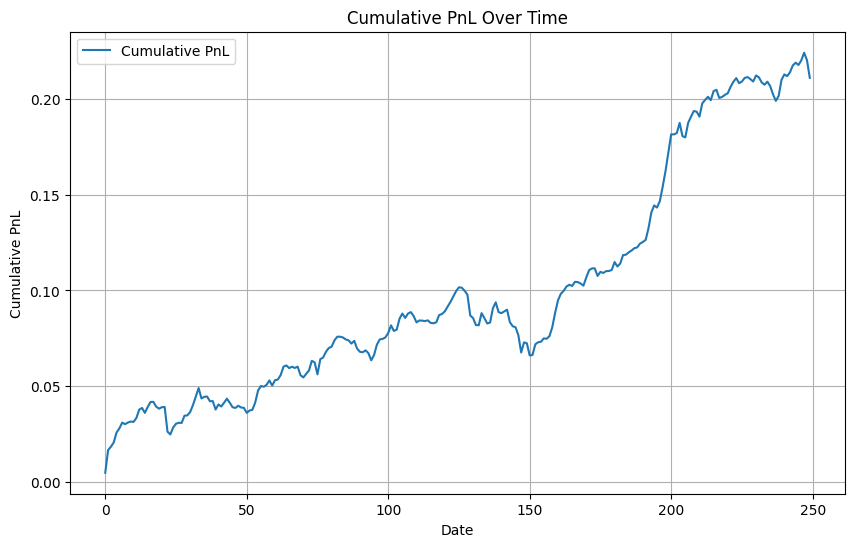

In [10]:
import matplotlib.pyplot as plt


# Tracez le PnL cumulatif
plt.figure(figsize=(10, 6))
plt.plot(PnL, label='Cumulative PnL')
plt.title('Cumulative PnL Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)
plt.show()

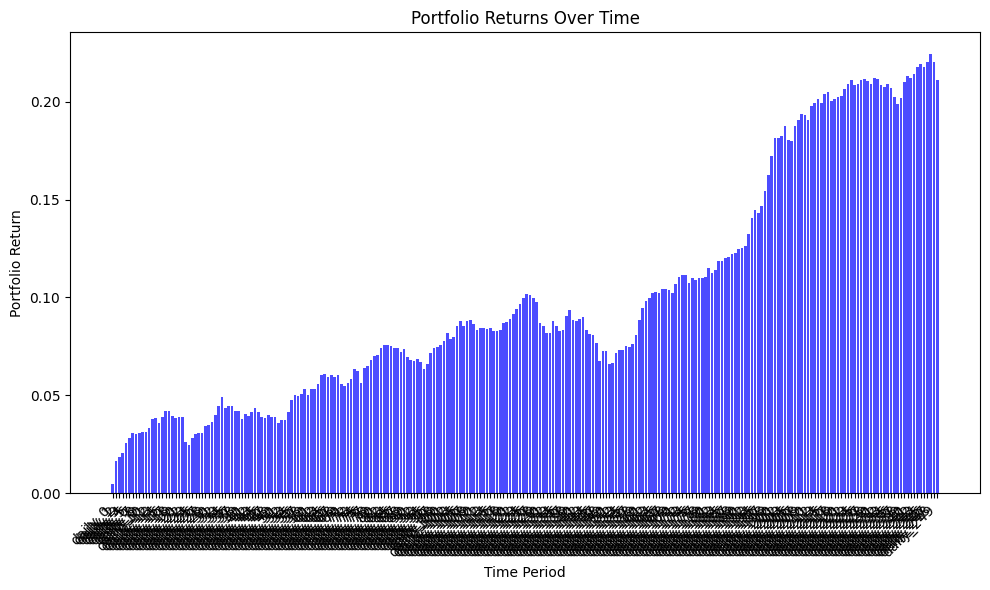

In [11]:
process.bar_plot_PnL(PnL)


In [28]:
Results=[]
Results.append([overall_return, PnL, portfolio_value, sharpe_ratio])

In [29]:
Results

[[            portfolio return
  15/03/2000          0.004825
  16/03/2000          0.011746
  17/03/2000          0.001542
  20/03/2000          0.002010
  21/03/2000          0.005050
  ...                      ...
  06/03/2001         -0.000892
  07/03/2001          0.002064
  08/03/2001          0.003291
  09/03/2001         -0.003171
  12/03/2001         -0.008438
  
  [250 rows x 1 columns],
  array([0.  , 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
         0.03, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
         0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.04, 0.04, 0.04,
         0.05, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
         0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.05,
         0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.06, 0.06, 0.06, 0.06,
         0.06, 0.06, 0.06, 0.06, 0.05, 0.06, 0.06, 0.06, 0.06, 0.05, 0.06,
         0.06, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07,

In [31]:
import warnings 


warnings.filterwarnings("ignore") ## so that there are no polluting warnings as output of this cell
for i in range(19):
    lookback_window_0 = [0+250*i, 50+250*i]
    number_of_clusters = 38
    sigma = 10e-2
    clustering_method = 'SPONGE' 
    number_of_repetition = 20
    number_of_window=50
    evaluation_window = 5
    eta=0.01

    overall_return, PnL, portfolio_value, sharpe_ratio = process.sliding_window(df_cleaned=df_cleaned, lookback_window_0=lookback_window_0, number_of_clusters=number_of_clusters, sigma=sigma, clustering_method=clustering_method, number_of_repetition=number_of_repetition, number_of_window=number_of_window, evaluation_window=evaluation_window, eta=eta)
    Results.append([overall_return, PnL, portfolio_value, sharpe_ratio])

1.0249424145643409
step 1
1.0303495333630828
step 2
1.0338972797307477
step 3
1.034941021913445
step 4
1.0249672225303152
step 5
1.0332452779002614
step 6
1.0417076172071187
step 7
1.0363517514241318
step 8
1.0410510542042357
step 9
1.0389803311364025
step 10
1.0478940366823193
step 11
1.0495160586839152
step 12
1.0597591095182302
step 13
1.05328051248995
step 14
1.0589397501592246
step 15
1.0674812445681099
step 16
1.0715958106142471
step 17
1.066269054648218
step 18
1.060408915006581
step 19
1.0729680694947257
step 20
1.0833253759021166
step 21
1.0847147839702196
step 22
1.080807870466408
step 23
1.083667377890155
step 24
1.096843026163705
step 25
1.0848356995226622
step 26
1.0856210261472146
step 27
1.088879489778831
step 28
1.0825916359191177
step 29
1.0729502716432244
step 30
1.0757414579152385
step 31
1.0918528086195736
step 32
1.1053398891795643
step 33
1.1069852622098593
step 34
1.1129397374057897
step 35
1.1160706970557597
step 36
1.1218241147792205
step 37
1.1265780442733562


ArpackNoConvergence: ARPACK error -1: ARPACK error -1: No convergence (371 iterations, 0/1 eigenvectors converged)


        CVXPY note: This failure was encountered while trying to certify
        that a matrix is positive semi-definite (see [1] for a definition).
        In rare cases, this method fails for numerical reasons even when the matrix is
        positive semi-definite. If you know that you're in that situation, you can
        replace the matrix A by cvxpy.psd_wrap(A).

        [1] https://en.wikipedia.org/wiki/Definite_matrix
        

In [47]:
Results[2][3]=(Results[2][2][-1]-1) / (Results[2][0].std()* np.sqrt(252))